## Домашка (10 баллов)


Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет). Как мимнимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на ф1 меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.


In [ ]:
%pip install --upgrade keras
%pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.4 which is incompatible.


In [ ]:
%pip install scikit-learn pandas matplotlib

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [ ]:
import keras
print(keras.__version__)

3.0.4


In [ ]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/lenta_40k.csv.zip')

In [ ]:
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [ ]:
len(vocab)

354611

In [ ]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
len(filtered_vocab)

24091

In [ ]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape

(44356, 200)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

только dense слои

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )
mean = keras.layers.Flatten()(embeddings)
dense = keras.layers.Dense(30, activation='relu')(mean)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              # фмеры тут нет, но есть точность и полнота по отдельности,
              # name тут нужен для удобства,
              # иначе метрика будет называться типа "Precision_i"
              # и придется менять i в дальнейших визуализациях
              metrics=[keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall')])

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 377ms/step - loss: 2.7913 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3996 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 545ms/step - loss: 2.3254 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.0924 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 382ms/step - loss: 2.0230 - precision: 0.4651 - recall: 9.8110e-04 - val_loss: 1.8122 - val_precision: 0.8614 - val_recall: 0.0392
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 403ms/step - loss: 1.7226 - precision: 0.9168 - recall: 0.0682 - val_loss: 1.5266 - val_precision: 0.9023 - val_recall: 0.2083
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 346ms/step - loss: 1.4308 - precision: 0.9040 - recall: 0.2463 - val_loss: 1.2955 - val_precision: 0.8485 - val_recall: 0.3814
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 401ms/step - loss: 1.1694 - precision: 0.8732 - recall: 0.4343 - val_loss: 1.1272 

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])


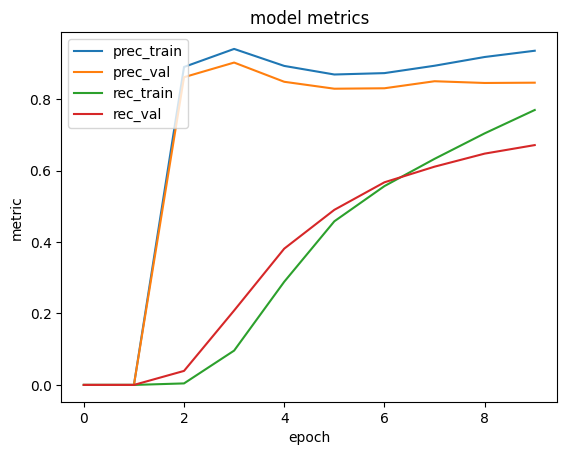

In [ ]:
print(model.history.history.keys())
plt.plot(model.history.history['precision'])
plt.plot(model.history.history['val_precision'])
plt.plot(model.history.history['recall'])
plt.plot(model.history.history['val_recall'])
plt.title('model metrics')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['prec_train', 'prec_val', 'rec_train', 'rec_val'], loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer (InputLayer)           │ (None, 200)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ embedding (Embedding)              │ (None, 200, 30)               │     722,760 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten (Flatten)                  │ (None, 6000)                  │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense (Dense)                      │ (None, 30)                    │     180,030 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 19)                    │         589 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 2,710,139 (10.34 MB)

 Trainable params: 903,379 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,806,760 (6.89 MB)

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

for ks in [2,3,4,5]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1,
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)
concat = keras.layers.concatenate(convs, axis=2)
conv_global = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = keras.layers.Flatten()(conv_global)
dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.save('model.keras')

In [ ]:
model.save_weights('model.weights.h5')

In [ ]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = keras.callbacks.EarlyStopping(monitor='val_f1',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 200)            │          0 │ -                          │
│ (InputLayer)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 200, 100)       │  2,409,200 │ input_layer_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d (Conv1D)           │ (None, 200, 32)        │      6,432 │ embedding_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 200, 32)        │      9,632 │ embedding_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 200, 32)        │     12,832 │ embedding_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 200, 32)        │     16,032 │ embedding_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 200, 32)        │      2,080 │ conv1d[0][0]               │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 200, 32)        │      3,104 │ conv1d_2[0][0]             │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 200, 32)        │      4,128 │ conv1d_4[0][0]             │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 200, 32)        │      5,152 │ conv1d_6[0][0]             │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ concatenate (Concatenate) │ (None, 200, 128)       │          0 │ conv1d_1[0][0],            │
│                           │                        │            │ conv1d_3[0][0],            │
│                           │                        │            │ conv1d_5[0][0],            │
│                           │                        │            │ conv1d_7[0][0]             │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 196, 32)        │     20,512 │ concatenate[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 6272)           │          0 │ conv1d_8[0][0]             │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dense_2 (Dense)           │ (None, 50)             │    313,650 │ flatten_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dense_3 (Dense)           │ (None, 19)             │        969 │ dense_2[0][0]              │
└───────────────────────────┴────────────────────────┴────────────┴────────────────────────────┘

 Total params: 2,803,723 (10.70 MB)

 Trainable params: 2,803,723 (10.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))

embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
drop1 = keras.layers.Dropout(0.3)(embeddings)
conv1 = keras.layers.Conv1D(kernel_size=3, filters=128, strides=1,
                                               kernel_regularizer='l2',
                                              activation='relu')(embeddings)
conv2 = keras.layers.Conv1D(kernel_size=5, filters=128, strides=2,
                                               kernel_regularizer='l2',
                                              activation='relu')(conv1)

drop2 = keras.layers.Dropout(0.5)(conv2) # это значит что случайно заменяется половина всех значений

flatten = keras.layers.Flatten()(drop2)
dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10,
         callbacks=[checkpoint, early_stop])

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 218s 10s/step - loss: 2.1668 - rec@prec: 2.4155e-06 - val_loss: 1.1182 - val_rec@prec: 0.0000e+00
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:205: UserWarning: Can save best model only with val_f1 available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_f1` which is not available. Available metrics are: loss,rec@prec,val_loss,val_rec@prec
  current = self.get_monitor_value(logs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 205s 9s/step - loss: 0.9211 - rec@prec: 4.7534e-05 - val_loss: 0.4882 - val_rec@prec: 0.0000e+00
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 202s 9s/step - loss: 0.4172 - rec@prec: 3.7879e-06 - val_loss: 0.2631 - val_rec@prec: 4.5086e-04
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 210s 10s/step - loss: 0.2396 - rec@prec: 0.0020 - val_loss: 0.1833 - val_rec@prec: 0.0077
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 214s 10s/step - loss: 0.1769 - rec@prec: 0.0135 - val_loss: 0.1573 - val_rec@prec: 0.0748
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 221s 10s/step - loss: 0.1555 - rec@prec: 0.0646 - val_loss: 0.1465 - val_rec@prec: 0.1154
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 218s 10s/step - loss: 0.1455 - rec@prec: 0.1166 - val_loss: 0.1456 - val_rec@prec: 0.1402
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 223s 10s/step - loss: 0.1437 - rec@prec: 0.1317 - val_loss: 0.1420 - val_rec@prec: 0.1537
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 227s 10s/step - loss: 0.1375 - rec@prec: 0.1797 - val_loss: 0.1

In [ ]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)         │ (None, 200)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ embedding_2 (Embedding)            │ (None, 200, 100)              │   2,409,200 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv1d_9 (Conv1D)                  │ (None, 198, 128)              │      38,528 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv1d_10 (Conv1D)                 │ (None, 97, 128)               │      82,048 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_1 (Dropout)                │ (None, 97, 128)               │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_2 (Flatten)                │ (None, 12416)                 │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_4 (Dense)                    │ (None, 50)                    │     620,850 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_5 (Dense)                    │ (None, 19)                    │         969 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 9,454,787 (36.07 MB)

 Trainable params: 3,151,595 (12.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,303,192 (24.04 MB)

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


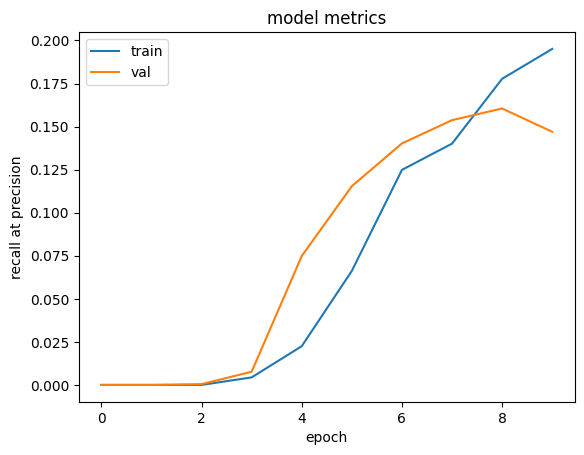

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))

embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
drop1 = keras.layers.Dropout(0.1)(embeddings)
conv1 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(embeddings)
conv2 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv1)
conv3 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1,
                                               kernel_regularizer='l2',
                                              activation='relu')(conv2)

conv4 = keras.layers.Conv1D(kernel_size=10, filters=32, strides=2, activation='relu')(conv3)
pool = keras.layers.AveragePooling1D(pool_size=5)(conv4)


drop2 = keras.layers.Dropout(0.1)(pool) # это значит что случайно заменяется половина всех значений

concat = keras.layers.Flatten()(drop2)
dense = keras.layers.Dense(50, activation='relu', kernel_regularizer='l2')(concat)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)         │ (None, 200)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ embedding_8 (Embedding)            │ (None, 200, 100)              │   2,409,200 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv1d_56 (Conv1D)                 │ (None, 196, 32)               │      16,032 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv1d_57 (Conv1D)                 │ (None, 192, 32)               │       5,152 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv1d_58 (Conv1D)                 │ (None, 188, 32)               │       5,152 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv1d_59 (Conv1D)                 │ (None, 90, 32)                │      10,272 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ average_pooling1d_2                │ (None, 18, 32)                │           0 │
│ (AveragePooling1D)                 │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_10 (Dropout)               │ (None, 18, 32)                │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_8 (Flatten)                │ (None, 576)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_16 (Dense)                   │ (None, 50)                    │      28,850 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_17 (Dense)                   │ (None, 19)                    │         969 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 2,475,627 (9.44 MB)

 Trainable params: 2,475,627 (9.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.save('model.keras')
model.save_weights('model.weights.h5')
model.load_weights('model.weights.h5')

In [ ]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = keras.callbacks.EarlyStopping(monitor='val_f1',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=2, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10,
         callbacks=[checkpoint, early_stop])

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - loss: 0.6758 - rec@prec: 1.0770e-04 - val_loss: 0.2246 - val_rec@prec: 4.5086e-04
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:205: UserWarning: Can save best model only with val_f1 available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_f1` which is not available. Available metrics are: loss,rec@prec,val_loss,val_rec@prec
  current = self.get_monitor_value(logs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - loss: 0.2028 - rec@prec: 0.0000e+00 - val_loss: 0.1562 - val_rec@prec: 0.0559
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - loss: 0.1525 - rec@prec: 0.0535 - val_loss: 0.1369 - val_rec@prec: 0.1799
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - loss: 0.1416 - rec@prec: 0.1462 - val_loss: 0.1507 - val_rec@prec: 0.1830
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - loss: 0.1415 - rec@prec: 0.1955 - val_loss: 0.1396 - val_rec@prec: 0.1650
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - loss: 0.1298 - rec@prec: 0.1988 - val_loss: 0.1297 - val_rec@prec: 0.1961
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - loss: 0.1168 - rec@prec: 0.2552 - val_loss: 0.1295 - val_rec@prec: 0.2353
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - loss: 0.1102 - rec@prec: 0.3319 - val_loss: 0.1368 - val_rec@prec: 0.1952
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - loss: 0.1067 - rec@prec: 0.3725 - val_loss: 0.1432 - val_rec@prec: 0

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


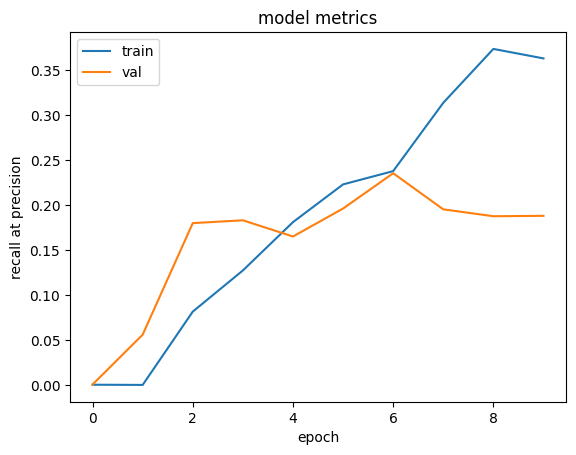

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## final_1

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
drop1 = keras.layers.Dropout(0.1)(embeddings)
convs = []

for ks in [3,4,5,7,10,12]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1,
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)


concat = keras.layers.concatenate(convs, axis=2)


conv_global = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
pool = keras.layers.AveragePooling1D(pool_size=5)(conv_global)
drop2 = keras.layers.Dropout(0.1)(pool)
flatten = keras.layers.Flatten()(drop2)
dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 200)            │          0 │ -                          │
│ (InputLayer)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ embedding_9 (Embedding)   │ (None, 200, 100)       │  2,409,200 │ input_layer_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_60 (Conv1D)        │ (None, 200, 32)        │      9,632 │ embedding_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_62 (Conv1D)        │ (None, 200, 32)        │     12,832 │ embedding_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_64 (Conv1D)        │ (None, 200, 32)        │     16,032 │ embedding_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_66 (Conv1D)        │ (None, 200, 32)        │     22,432 │ embedding_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_68 (Conv1D)        │ (None, 200, 32)        │     32,032 │ embedding_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_70 (Conv1D)        │ (None, 200, 32)        │     38,432 │ embedding_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_61 (Conv1D)        │ (None, 200, 32)        │      3,104 │ conv1d_60[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_63 (Conv1D)        │ (None, 200, 32)        │      4,128 │ conv1d_62[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_65 (Conv1D)        │ (None, 200, 32)        │      5,152 │ conv1d_64[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_67 (Conv1D)        │ (None, 200, 32)        │      7,200 │ conv1d_66[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_69 (Conv1D)        │ (None, 200, 32)        │     10,272 │ conv1d_68[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_71 (Conv1D)        │ (None, 200, 32)        │     12,320 │ conv1d_70[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ concatenate_4             │ (None, 200, 192)       │          0 │ conv1d_61[0][0],           │
│ (Concatenate)             │                        │            │ conv1d_63[0][0],           │
│                           │                        │            │ conv1d_65[0][0],           │
│                           │                        │            │ conv1d_67[0][0],           │
│                           │                        │            │ conv1d_69[0][0],           │
│                           │                        │            │ conv1d_71[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_72 (Conv1D)        │ (None, 196, 32)        │     30,752 │ concatenate_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ average_pooling1d_3  

 Total params: 2,676,939 (10.21 MB)

 Trainable params: 2,676,939 (10.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.save('model.keras')
model.save_weights('model.weights.h5')

In [ ]:
model.load_weights('model.weights.h5')

In [ ]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = keras.callbacks.EarlyStopping(monitor='val_f1',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=2, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10,
         callbacks=[checkpoint, early_stop])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/torch/nn.py:403: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  outputs = tnn.conv1d(


22/22 ━━━━━━━━━━━━━━━━━━━━ 582s 26s/step - loss: 1.8686 - rec@prec: 4.3478e-06 - val_loss: 1.2394 - val_rec@prec: 0.0000e+00
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 556s 25s/step - loss: 1.0948 - rec@prec: 2.7783e-04 - val_loss: 0.7328 - val_rec@prec: 0.0000e+00
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 550s 25s/step - loss: 0.6494 - rec@prec: 0.0012 - val_loss: 0.4398 - val_rec@prec: 0.0726
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 549s 25s/step - loss: 0.3903 - rec@prec: 0.1330 - val_loss: 0.2727 - val_rec@prec: 0.3530
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 550s 25s/step - loss: 0.2421 - rec@prec: 0.4273 - val_loss: 0.1901 - val_rec@prec: 0.4500
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 551s 25s/step - loss: 0.1624 - rec@prec: 0.5648 - val_loss: 0.1483 - val_rec@prec: 0.4937
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 549s 25s/step - loss: 0.1167 - rec@prec: 0.6479 - val_loss: 0.1294 - val_rec@prec: 0.5050
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 555s 25s/step - loss: 0.0903 - rec@prec: 0.7116 - val_loss: 0

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


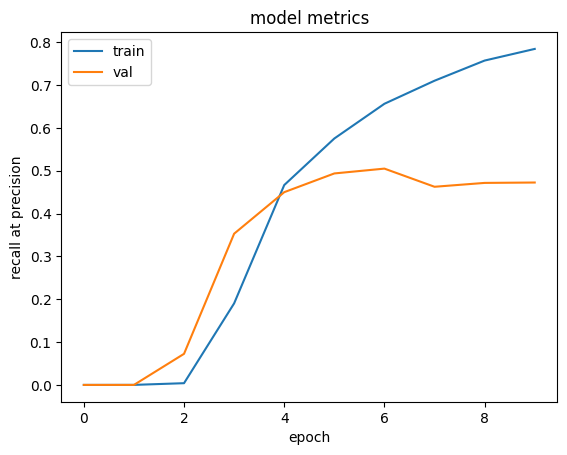

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## final_2

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
drop1 = keras.layers.Dropout(0.1)(embeddings)
convs = []

for ks in [3,4,5,7,10]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=32, strides=1, activation='relu')(conv1)
    conv3 = keras.layers.Conv1D(kernel_size=ks, filters=32, strides=1,
                                               kernel_regularizer='l2',
                                              activation='relu')(conv2)

    convs.append(conv3)


concat = keras.layers.concatenate(convs, axis=1)


conv_global = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
pool = keras.layers.AveragePooling1D(pool_size=5)(conv_global)
drop2 = keras.layers.Dropout(0.1)(pool)
flatten = keras.layers.Flatten()(drop2)
dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 200)            │          0 │ -                          │
│ (InputLayer)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ embedding_18 (Embedding)  │ (None, 200, 100)       │  2,409,200 │ input_layer_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_193 (Conv1D)       │ (None, 200, 32)        │      9,632 │ embedding_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_196 (Conv1D)       │ (None, 200, 32)        │     12,832 │ embedding_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_199 (Conv1D)       │ (None, 200, 32)        │     16,032 │ embedding_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_202 (Conv1D)       │ (None, 200, 32)        │     22,432 │ embedding_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_205 (Conv1D)       │ (None, 200, 32)        │     32,032 │ embedding_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_194 (Conv1D)       │ (None, 198, 32)        │      3,104 │ conv1d_193[0][0]           │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_197 (Conv1D)       │ (None, 197, 32)        │      4,128 │ conv1d_196[0][0]           │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_200 (Conv1D)       │ (None, 196, 32)        │      5,152 │ conv1d_199[0][0]           │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_203 (Conv1D)       │ (None, 194, 32)        │      7,200 │ conv1d_202[0][0]           │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_206 (Conv1D)       │ (None, 191, 32)        │     10,272 │ conv1d_205[0][0]           │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_195 (Conv1D)       │ (None, 196, 32)        │      3,104 │ conv1d_194[0][0]           │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_198 (Conv1D)       │ (None, 194, 32)        │      4,128 │ conv1d_197[0][0]           │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_201 (Conv1D)       │ (None, 192, 32)        │      5,152 │ conv1d_200[0][0]           │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_204 (Conv1D)       │ (None, 188, 32)        │      7,200 │ conv1d_203[0][0]           │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_207 (Conv1D)       │ (None, 182, 32)        │     10,272 │ conv1d_206[0][0]           │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ concatenate_13            │ (None, 952, 32)        │          0 │ conv1d_195[0][0],          │
│ (Concatenate)             │                        │            │ conv1d_198[0][0],          │
│                           │                        │            │ conv1d_201[0][0],          │
│                      

 Total params: 2,870,443 (10.95 MB)

 Trainable params: 2,870,443 (10.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.save('model.keras')
model.save_weights('model.weights.h5')
model.load_weights('model.weights.h5')

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )


early_stop = keras.callbacks.EarlyStopping(monitor='val_f1',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=2, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10,
         callbacks=[checkpoint, early_stop])

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 582s 26s/step - loss: 1.6155 - rec@prec: 3.6232e-06 - val_loss: 1.1126 - val_rec@prec: 4.5086e-04
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:205: UserWarning: Can save best model only with val_f1 available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_f1` which is not available. Available metrics are: loss,rec@prec,val_loss,val_rec@prec
  current = self.get_monitor_value(logs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 556s 25s/step - loss: 0.9937 - rec@prec: 7.9746e-05 - val_loss: 0.6864 - val_rec@prec: 0.0018
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 558s 25s/step - loss: 0.6141 - rec@prec: 0.0126 - val_loss: 0.4223 - val_rec@prec: 0.1970
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 565s 26s/step - loss: 0.3778 - rec@prec: 0.3131 - val_loss: 0.2725 - val_rec@prec: 0.3837
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 552s 25s/step - loss: 0.2384 - rec@prec: 0.5102 - val_loss: 0.1905 - val_rec@prec: 0.5041
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 537s 24s/step - loss: 0.1558 - rec@prec: 0.6481 - val_loss: 0.1484 - val_rec@prec: 0.5162
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 558s 25s/step - loss: 0.1050 - rec@prec: 0.7667 - val_loss: 0.1250 - val_rec@prec: 0.5649
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 560s 25s/step - loss: 0.0737 - rec@prec: 0.8437 - val_loss: 0.1167 - val_rec@prec: 0.5676
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 558s 25s/step - loss: 0.0525 - rec@prec: 0.9044 - val_loss: 0.1215 - val_

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


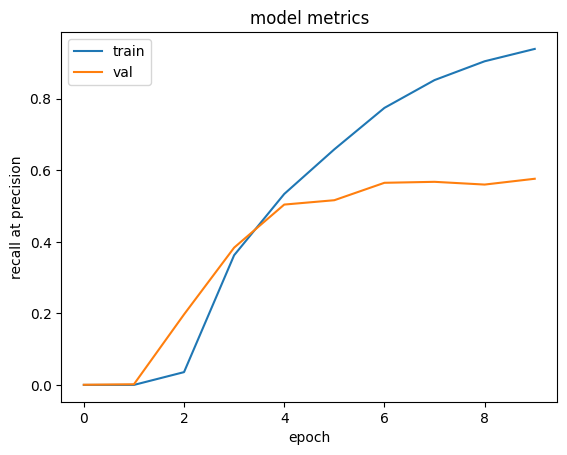

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()